In [16]:
import pickle as pkl
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import networkx as nx
import os.path as op
import os
import csv
import math

%matplotlib inline

### Load all demographic + connectome data

(this is specific to train set files, so change to test when it comes to it)

remember not all are formatted exactly the same: degdist + meanconn differ from the rest

In [22]:
# dat connectome feature info
locstat = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_locstat.pkl','rb'))
nnonzero = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_nnonzero.pkl','rb'))
bwcent = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_bwcent.pkl','rb'))
edgewt = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_edgewt_new.pkl','rb'))
eigseq = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_eigseq.pkl','rb'))
cfclust = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_cfclust.pkl','rb'))
degdist = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_degdist.pkl','rb'))
meanconn = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_meanconn.pkl','rb'))

# dat TRAIN demographic info
age = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_ages.pkl', 'rb')) # dict of subjids: ages
behav = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_behav.pkl', 'rb')) # dict of subjids: {demog/cog: data}
subjids = pkl.load(open('/Users/nalsharif/code/nooralsh/ping_proc/data/train_subjids.pkl','rb')) # list of subjids

## Bin ages

### By setting 'floor' and 'ceiling'

In [41]:
age_flr = {}
for subj in age:
    age_flr[subj] = np.floor(age[subj])

age_ceil = {}
for subj in age:
    age_ceil[subj] = np.ceil(age[subj])

binages = [ x for x in set(age_flr.values()) if x==x ]
len(binages)

19

### ... or by setting pre-determined groups

(this code could probably be improved)

In [86]:
age_bins = {}
for subj in age:
    if age[subj] > 3 and age[subj] <= 6:
        age_bins[subj] = 1
        #print(age_bins[subj],age[subj])
    elif age[subj] > 6 and age[subj] <= 9:
        age_bins[subj] = 2
    elif age[subj] > 9 and age[subj] <= 12:
        age_bins[subj] = 3
    elif age[subj] > 12 and age[subj] <= 15:
        age_bins[subj] = 4
    elif age[subj] > 15 and age[subj] <= 18:
        age_bins[subj] = 5
    elif age[subj] > 18:
        age_bins[subj] = 6

#age_bins

binages = [ x for x in set(age_bins.values()) if x==x ]
len(binages)

6

### Make a function that creates confidence intervals based on mean

In [63]:
# def mean_confidence_interval(data, confidence=0.95):
# #     a = 1.0*np.array(data)
#     n = len(data)
#     m, se = np.mean(data), scipy.stats.sem(data)
# #     h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
# #    return m, m-h, m+h
#     return m, se

In [87]:
# make a numpy matrix of no. of age brackets x 70 (bc 70 features)
# these are your various objects: degdist, age, behav, subjids

avg_mat = np.zeros((len(binages),70))
se_mn = np.zeros((len(binages),70))

for idx1,a in enumerate(binages):
    tlist = []
    
    for subj in age_bins:
        if age_bins[subj] == a:
            # get degree distribution for all subjects within an age range
            tlist += [ degdist['total_deg'][subj] ]

    nsubjs = len(tlist)
#     print(nsubjs)
    tmat = np.zeros((nsubjs,70))
    
    # make a temporary matrix for a single age group
    for idx2,titem in enumerate(tlist):
        tmat[idx2,:] = np.array(titem)
#     print(tmat.shape, tmat.dtype)
    
    #average those features across first axis & put into a row of avg_mat
    tavgmat = np.mean(tmat,axis = 0)
#     print(tavgmat)
#     ttuple = mean_confidence_interval(tavgmat)
#     se_mn += [ttuple[1]]
    se_mn[idx1,:] = scipy.stats.sem(tmat)

    avg_mat[idx1,:]=tavgmat

# print(se_mn)
            
# for c in enumerate():
#     mymat[c,:] = my 1x70 avg

In [88]:
print(se_mn)

[[1.08259154 0.69034444 0.78844747 1.21901842 1.29033446 0.57708331
  0.73990744 0.78779522 0.58659836 0.73187164 0.85969497 0.57517041
  0.7182274  0.82698121 0.6163274  0.65015929 0.86059787 1.09677783
  0.73363809 0.45632472 0.6026507  0.61120576 0.90790007 1.16953121
  1.09319777 0.82037659 0.73765481 0.66505105 1.1709691  0.71025352
  0.77808843 0.8660553  0.53269578 0.22522178 0.76964892 1.09191149
  0.81856239 0.77460622 1.15685505 1.20769231 0.59237637 0.72717741
  0.79111654 0.6562456  0.70318906 1.10015464 0.67045092 0.69702984
  0.79254571 0.69319921 0.64603364 0.79321736 1.16872775 0.69653092
  0.4548392  0.70582425 0.62518045 0.85659208 1.24009985 1.34738405
  0.89032439 0.72555325 0.75639287 1.16393665 0.77711346 0.75939383
  0.96389327 0.40797342 0.52737908 0.73429312]
 [1.02515328 0.63693051 0.63039362 1.03705555 1.05685063 0.44688763
  0.61489113 0.63044774 0.48513286 0.64342387 0.79754281 0.49922878
  0.61456342 0.62361667 0.55395726 0.64342387 0.68220626 0.9058054
  

(0, 70)

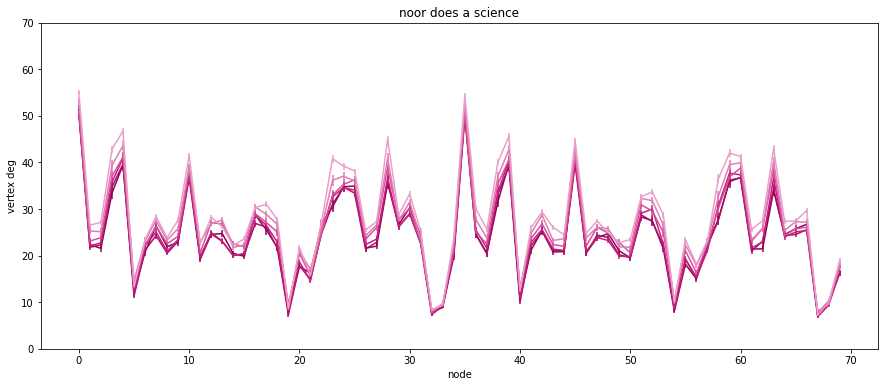

In [83]:
piyg = plt.get_cmap('PiYG')
plt.figure(figsize=(15,6))
for idx,avg in enumerate(avg_mat):
#    print(idx,avg)
#   col = piyg(int( (age[subj] - 3)/19 *255))
    col = piyg(int((binages[idx]-3)/19 * 255))
#    plt.plot(avg_mat[idx], c=col)
#    plt.errorbar(np.arange(70)+idx*0.03, avg_mat[idx], se_mn[idx], c=col)
    plt.errorbar(np.arange(70), avg_mat[idx], se_mn[idx], c=col)


plt.title('noor does a science')
plt.ylabel('vertex deg')
plt.xlabel('node')
plt.ylim([0, 70])

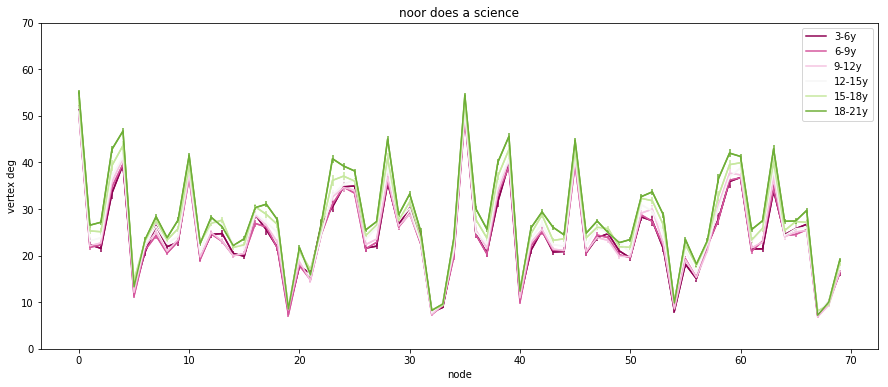

In [91]:
labels = ['3-6y','6-9y','9-12y','12-15y','15-18y','18-21y']
#linestyles = ['-', '--', '-.', ':']

piyg = plt.get_cmap('PiYG')
plt.figure(figsize=(15,6))

for idx,avg in enumerate(avg_mat):
    col = piyg(int((binages[idx]-1)/6.0 * 255))
    label = labels[idx]
#    linestyle = linestyles[idx]
    plt.plot(avg_mat[idx], c=col, label=label)
    plt.errorbar(np.arange(70), avg_mat[idx], se_mn[idx], c=col)


plt.title('noor does a science')
plt.ylabel('vertex deg')
plt.xlabel('node')
plt.ylim([0, 70])
plt.legend()

# WHAT HAPPENED TO ALL THOSE GRAPHS?
- with binned ages and cog scores
- also that long script where you could change the cog task p easily to make new graphs